In [2]:
import numpy as np
import pickle as pickle
import pandas as pd
import math
import seaborn as sns

import matplotlib.pyplot as plt
import pywt

from sklearn import svm
from sklearn.preprocessing import normalize

import os
import time
import tensorflow as tf
from tensorflow import keras

from keras.utils import to_categorical

from keras.models import Sequential
from keras.models import load_model

from keras.layers import Conv1D, MaxPooling1D
from keras.layers import BatchNormalization, Activation, Dropout, Flatten, Dense

from keras.layers import Bidirectional, TimeDistributed
from keras.layers import LSTM, GRU, SimpleRNN

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.regularizers import l2

from sklearn.metrics import confusion_matrix, classification_report

# Load .dat file and check shape for data and labels array


In [5]:
import pickle
import numpy as np

# Define the path to the data file
file_path = '/content/drive/MyDrive/DEAP/data_preprocessed_python/s01.dat'

# Load a participant's data file with the correct encoding
with open(file_path, 'rb') as file:
    participant_data = pickle.load(file, encoding='latin1')
    print(type(participant_data))


# Extract data and labels
data = participant_data['data']
labels = participant_data['labels']
print("Type:", type(data))
print("Data shape:", data.shape)
print("Type: ", type(labels))
print("Labels shape:", labels.shape)


<class 'dict'>
Type: <class 'numpy.ndarray'>
Data shape: (40, 40, 8064)
Type:  <class 'numpy.ndarray'>
Labels shape: (40, 4)


# Checking ratings for valence and arousal

In [6]:
# Extract valence and arousal ratings
valence_ratings = labels[:, 0]
arousal_ratings = labels[:, 1]

# Print sample ratings
print("Valence Ratings Sample:", valence_ratings[:10])
print("Arousal Ratings Sample:", arousal_ratings[:10])


Valence Ratings Sample: [7.71 8.1  8.58 4.94 6.96 8.27 7.44 7.32 4.04 1.99]
Arousal Ratings Sample: [7.6  7.31 7.54 6.01 3.92 3.92 3.73 2.55 3.29 4.86]


# Convert to numpy array

In [7]:
data_array = np.array(data)
labels_array = np.array(labels)


In [8]:
print("Type of data_array:", type(data_array))
print("Shape of data_array:", data_array.shape)  # Should be (40, 40, 8064)
print("Type of labels_array:", type(labels_array))
print("Shape of labels_array:", labels_array.shape)

Type of data_array: <class 'numpy.ndarray'>
Shape of data_array: (40, 40, 8064)
Type of labels_array: <class 'numpy.ndarray'>
Shape of labels_array: (40, 4)


In [9]:

trial_1_channel_1 = data[0, 0, :]
print(trial_1_channel_1)

trial_1_labels = labels[0, :]
print("Valence:", trial_1_labels[0])
print("Arousal:", trial_1_labels[1])
print("Dominance:", trial_1_labels[2])
print("Liking:", trial_1_labels[3])


[ 0.94823168  1.65333533  3.01372577 ... -2.82648937 -4.47722969
 -3.67692812]
Valence: 7.71
Arousal: 7.6
Dominance: 6.9
Liking: 7.83


In [10]:
import os

# Function to load .dat file from path

In [11]:
def load_dat_file(file_path):
    with open(file_path, 'rb') as file:
        participant_data = pickle.load(file, encoding='latin1')
    data = np.array(participant_data['data'])
    labels = np.array(participant_data['labels'])
    return data, labels


# Function to load multiple files from folder

In [12]:
def load_dat_files_from_folder(folder_path):
    data_list = []
    labels_list = []
    file_names = os.listdir(folder_path)
    for file_name in file_names:
        if file_name.endswith('.dat'):
            file_path = os.path.join(folder_path, file_name)
            data, labels = load_dat_file(file_path)
            data_list.append(data)
            labels_list.append(labels)
    return data_list, labels_list


# Analyze data and labels

In [14]:

folder_path = '/content/drive/MyDrive/DEAP/data_preprocessed_python'


data_list, labels_list = load_dat_files_from_folder(folder_path)


num_files = len(data_list)
print(f"Number of files loaded: {num_files}")

# Analyze data and labels
for i in range(num_files):

    print(f"File {i+1}:")
    print(f"  Data shape: {data_list[i].shape}")
    print(f"  Labels shape: {labels_list[i].shape}")

    first_trial_labels = labels_list[i][0]
    print(f"  First trial labels: Valence={first_trial_labels[0]}, Arousal={first_trial_labels[1]}, Dominance={first_trial_labels[2]}, Liking={first_trial_labels[3]}")


Number of files loaded: 32
File 1:
  Data shape: (40, 40, 8064)
  Labels shape: (40, 4)
  First trial labels: Valence=7.71, Arousal=7.6, Dominance=6.9, Liking=7.83
File 2:
  Data shape: (40, 40, 8064)
  Labels shape: (40, 4)
  First trial labels: Valence=9.0, Arousal=5.03, Dominance=7.13, Liking=6.62
File 3:
  Data shape: (40, 40, 8064)
  Labels shape: (40, 4)
  First trial labels: Valence=5.33, Arousal=4.67, Dominance=4.97, Liking=4.45
File 4:
  Data shape: (40, 40, 8064)
  Labels shape: (40, 4)
  First trial labels: Valence=6.68, Arousal=5.03, Dominance=8.22, Liking=8.14
File 5:
  Data shape: (40, 40, 8064)
  Labels shape: (40, 4)
  First trial labels: Valence=6.97, Arousal=4.9, Dominance=2.99, Liking=5.92
File 6:
  Data shape: (40, 40, 8064)
  Labels shape: (40, 4)
  First trial labels: Valence=8.19, Arousal=4.13, Dominance=6.56, Liking=7.47
File 7:
  Data shape: (40, 40, 8064)
  Labels shape: (40, 4)
  First trial labels: Valence=8.1, Arousal=4.01, Dominance=1.92, Liking=7.06
File 

# Participant wise label ratings for their trials

In [15]:
for participant_index, labels in enumerate(labels_list):
    print(f"Participant {participant_index + 1}:")
    num_trials = labels.shape[0]
    for trial_index in range(num_trials):
        valence = labels[trial_index, 0]
        arousal = labels[trial_index, 1]
        dominance = labels[trial_index, 2]
        liking = labels[trial_index, 3]
        print(f"  Trial {trial_index + 1}: Valence={valence}, Arousal={arousal}, Dominance={dominance}, Liking={liking}")


Participant 1:
  Trial 1: Valence=7.71, Arousal=7.6, Dominance=6.9, Liking=7.83
  Trial 2: Valence=8.1, Arousal=7.31, Dominance=7.28, Liking=8.47
  Trial 3: Valence=8.58, Arousal=7.54, Dominance=9.0, Liking=7.08
  Trial 4: Valence=4.94, Arousal=6.01, Dominance=6.12, Liking=8.06
  Trial 5: Valence=6.96, Arousal=3.92, Dominance=7.19, Liking=6.05
  Trial 6: Valence=8.27, Arousal=3.92, Dominance=7.0, Liking=8.03
  Trial 7: Valence=7.44, Arousal=3.73, Dominance=7.08, Liking=7.04
  Trial 8: Valence=7.32, Arousal=2.55, Dominance=6.32, Liking=5.87
  Trial 9: Valence=4.04, Arousal=3.29, Dominance=3.62, Liking=5.99
  Trial 10: Valence=1.99, Arousal=4.86, Dominance=2.04, Liking=7.09
  Trial 11: Valence=2.99, Arousal=2.36, Dominance=3.63, Liking=6.24
  Trial 12: Valence=2.71, Arousal=2.77, Dominance=3.4, Liking=7.35
  Trial 13: Valence=1.95, Arousal=3.12, Dominance=2.87, Liking=6.18
  Trial 14: Valence=4.18, Arousal=2.24, Dominance=3.04, Liking=5.04
  Trial 15: Valence=3.17, Arousal=8.08, Dominanc

# Convert entire data and labels into arrays

In [16]:
# Convert data and labels into arrays
all_data = np.concatenate(data_list, axis=0)
all_labels = np.concatenate(labels_list, axis=0)

# Print shape of concatenated arrays
print("Shape of all_data:", all_data.shape)
print("Shape of all_labels:", all_labels.shape)


Shape of all_data: (1280, 40, 8064)
Shape of all_labels: (1280, 4)


# Data Description
all_data has a shape of (N, C, T), where:
N is the total number of trials across all participants,
C is the number of channels,
T is the number of time points.

all_labels has a shape of (N, 4), where:
N is again the total number of trials across all participants,
The second dimension 4 represents the four ratings (e.g., valence, arousal, dominance, liking) for each trial.

In [17]:
# Print shape of concatenated arrays
print("Shape of all_data:", all_data.shape)
print("Shape of all_labels:", all_labels.shape)


Shape of all_data: (1280, 40, 8064)
Shape of all_labels: (1280, 4)


In [18]:
# Calculate summary statistics for ratings (assuming labels are in columns)
ratings_summary = np.mean(all_labels, axis=0)
print("Mean Ratings (Valence, Arousal, Dominance, Liking):", ratings_summary)


Mean Ratings (Valence, Arousal, Dominance, Liking): [5.2543125  5.15671094 5.38275    5.51813281]


In [19]:
# Assuming all_labels contains the labels for all participants and trials
num_trials = all_labels.shape[0]
num_ratings = all_labels.shape[1]

print(f"Total number of trials: {num_trials}")
print(f"Number of ratings per trial: {num_ratings}")

# Print label ratings for all data points
for i in range(num_trials):
    valence = all_labels[i, 0]
    arousal = all_labels[i, 1]
    dominance = all_labels[i, 2]
    liking = all_labels[i, 3]
    print(f"Trial {i+1}: Valence={valence}, Arousal={arousal}, Dominance={dominance}, Liking={liking}")


Total number of trials: 1280
Number of ratings per trial: 4
Trial 1: Valence=7.71, Arousal=7.6, Dominance=6.9, Liking=7.83
Trial 2: Valence=8.1, Arousal=7.31, Dominance=7.28, Liking=8.47
Trial 3: Valence=8.58, Arousal=7.54, Dominance=9.0, Liking=7.08
Trial 4: Valence=4.94, Arousal=6.01, Dominance=6.12, Liking=8.06
Trial 5: Valence=6.96, Arousal=3.92, Dominance=7.19, Liking=6.05
Trial 6: Valence=8.27, Arousal=3.92, Dominance=7.0, Liking=8.03
Trial 7: Valence=7.44, Arousal=3.73, Dominance=7.08, Liking=7.04
Trial 8: Valence=7.32, Arousal=2.55, Dominance=6.32, Liking=5.87
Trial 9: Valence=4.04, Arousal=3.29, Dominance=3.62, Liking=5.99
Trial 10: Valence=1.99, Arousal=4.86, Dominance=2.04, Liking=7.09
Trial 11: Valence=2.99, Arousal=2.36, Dominance=3.63, Liking=6.24
Trial 12: Valence=2.71, Arousal=2.77, Dominance=3.4, Liking=7.35
Trial 13: Valence=1.95, Arousal=3.12, Dominance=2.87, Liking=6.18
Trial 14: Valence=4.18, Arousal=2.24, Dominance=3.04, Liking=5.04
Trial 15: Valence=3.17, Arousal

# Plots for all data and all labels

In [20]:
import matplotlib.pyplot as plt

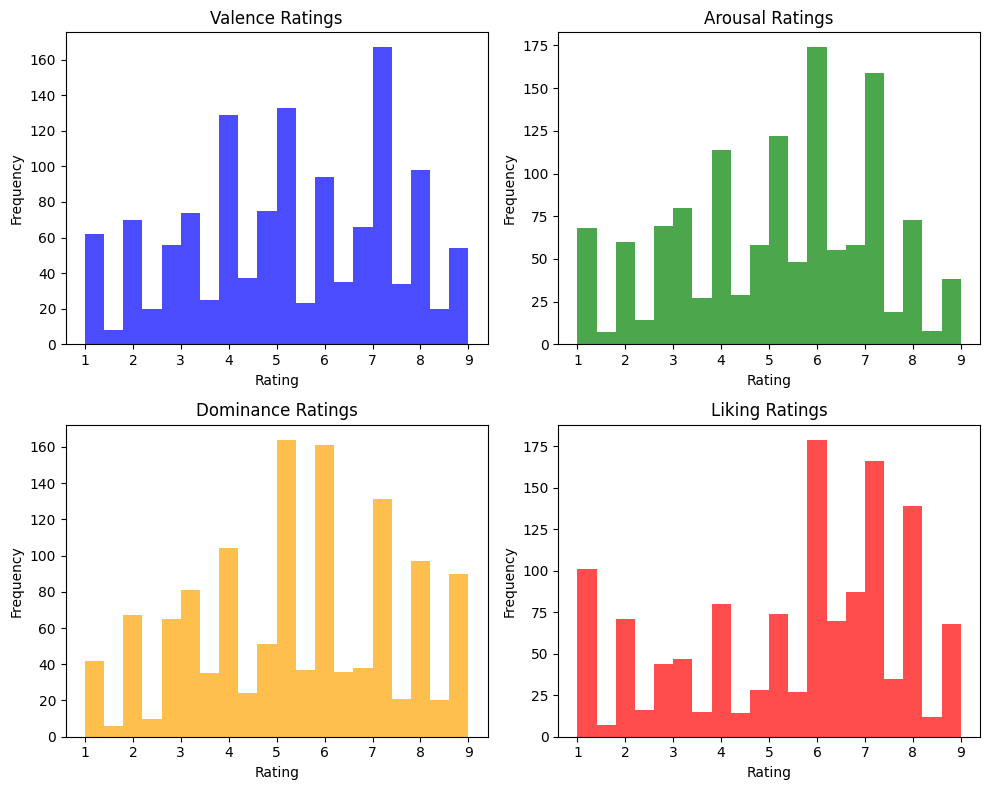

In [21]:
# Plot histograms of ratings
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].hist(all_labels[:, 0], bins=20, color='blue', alpha=0.7)
axs[0, 0].set_title('Valence Ratings')
axs[0, 0].set_xlabel('Rating')
axs[0, 0].set_ylabel('Frequency')

axs[0, 1].hist(all_labels[:, 1], bins=20, color='green', alpha=0.7)
axs[0, 1].set_title('Arousal Ratings')
axs[0, 1].set_xlabel('Rating')
axs[0, 1].set_ylabel('Frequency')

axs[1, 0].hist(all_labels[:, 2], bins=20, color='orange', alpha=0.7)
axs[1, 0].set_title('Dominance Ratings')
axs[1, 0].set_xlabel('Rating')
axs[1, 0].set_ylabel('Frequency')

axs[1, 1].hist(all_labels[:, 3], bins=20, color='red', alpha=0.7)
axs[1, 1].set_title('Liking Ratings')
axs[1, 1].set_xlabel('Rating')
axs[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


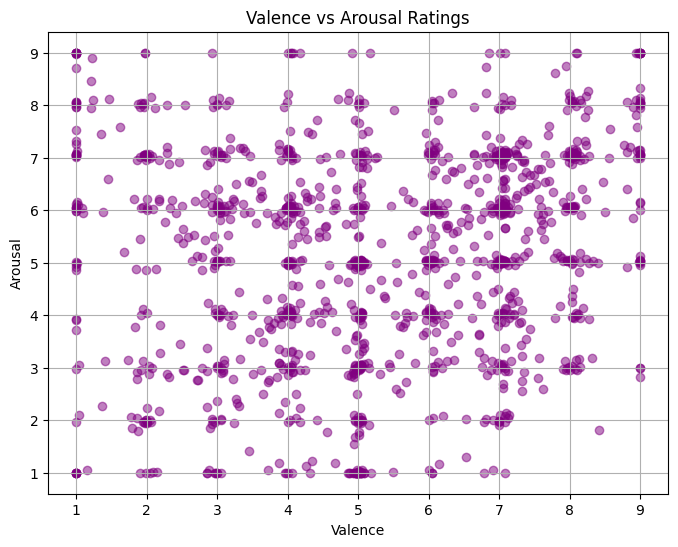

In [22]:
# Scatter plot of Valence vs Arousal ratings
plt.figure(figsize=(8, 6))
plt.scatter(all_labels[:, 0], all_labels[:, 1], color='purple', alpha=0.5)
plt.title('Valence vs Arousal Ratings')
plt.xlabel('Valence')
plt.ylabel('Arousal')
plt.grid(True)
plt.show()


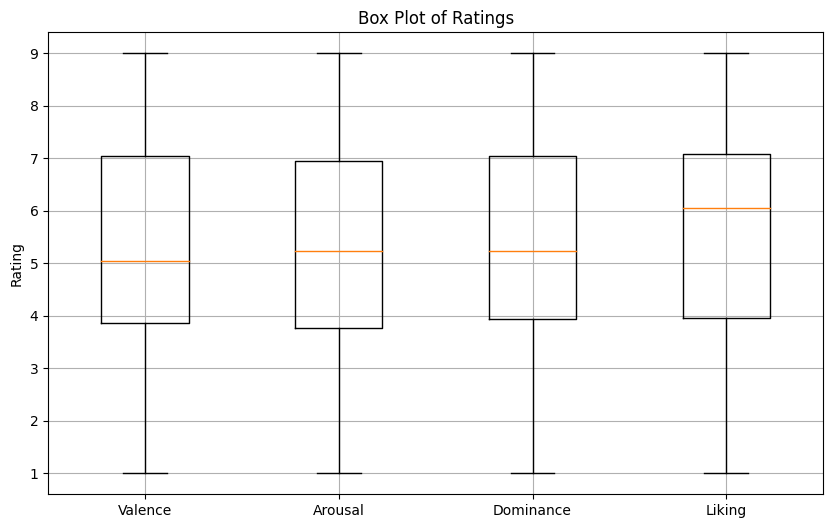

In [23]:
# Box plot of all ratings
plt.figure(figsize=(10, 6))
plt.boxplot(all_labels, labels=['Valence', 'Arousal', 'Dominance', 'Liking'])
plt.title('Box Plot of Ratings')
plt.ylabel('Rating')
plt.grid(True)
plt.show()


# Separating EEG and non-EEG data

In [24]:

# Assuming the first 32 channels are EEG signals
# Assuming the first 32 channels are EEG signals and the remaining are non-EEG signals
eeg_channels = 32
total_channels = all_data.shape[1]

if total_channels > eeg_channels:
    # Extract EEG data
    eeg_data = all_data[:, :eeg_channels, :]
    # Extract non-EEG data (remaining channels)
    non_eeg_data = all_data[:, eeg_channels:, :]
else:
    raise ValueError("The dataset does not have the expected number of channels for separation.")

# Print shapes to verify
print("Shape of EEG data:", eeg_data.shape)
print("Shape of Non-EEG data:", non_eeg_data.shape)

# Example: Checking the modalities present in the dataset (assuming known order)
channel_descriptions = [
    "EEG1", "EEG2", "EEG3", "EEG4", "EEG5", "EEG6", "EEG7", "EEG8",
    "EEG9", "EEG10", "EEG11", "EEG12", "EEG13", "EEG14", "EEG15", "EEG16",
    "EEG17", "EEG18", "EEG19", "EEG20", "EEG21", "EEG22", "EEG23", "EEG24",
    "EEG25", "EEG26", "EEG27", "EEG28", "EEG29", "EEG30", "EEG31", "EEG32",
    "EOG1", "EOG2", "GSR", "Respiration belt", "Plethysmograph", "Temperature"
]

print("Channel Descriptions:")
for i, desc in enumerate(channel_descriptions[:total_channels]):
    print(f"Channel {i+1}: {desc}")


Shape of EEG data: (1280, 32, 8064)
Shape of Non-EEG data: (1280, 8, 8064)
Channel Descriptions:
Channel 1: EEG1
Channel 2: EEG2
Channel 3: EEG3
Channel 4: EEG4
Channel 5: EEG5
Channel 6: EEG6
Channel 7: EEG7
Channel 8: EEG8
Channel 9: EEG9
Channel 10: EEG10
Channel 11: EEG11
Channel 12: EEG12
Channel 13: EEG13
Channel 14: EEG14
Channel 15: EEG15
Channel 16: EEG16
Channel 17: EEG17
Channel 18: EEG18
Channel 19: EEG19
Channel 20: EEG20
Channel 21: EEG21
Channel 22: EEG22
Channel 23: EEG23
Channel 24: EEG24
Channel 25: EEG25
Channel 26: EEG26
Channel 27: EEG27
Channel 28: EEG28
Channel 29: EEG29
Channel 30: EEG30
Channel 31: EEG31
Channel 32: EEG32
Channel 33: EOG1
Channel 34: EOG2
Channel 35: GSR
Channel 36: Respiration belt
Channel 37: Plethysmograph
Channel 38: Temperature


In [25]:
# Example: Checking the first few EEG signals for the first trial
print("EEG signals for the first trial:", eeg_data[0, :, :5])

# Example: Checking the first few non-EEG signals for the first trial
print("Non-EEG signals for the first trial:", non_eeg_data[0, :, :5])

# Example: Checking the labels for the first trial
trial_1_labels = all_labels[0, :]
print("Labels for the first trial:")
print(f"  Valence: {trial_1_labels[0]}")
print(f"  Arousal: {trial_1_labels[1]}")
print(f"  Dominance: {trial_1_labels[2]}")
print(f"  Liking: {trial_1_labels[3]}")


EEG signals for the first trial: [[ 0.94823168  1.65333533  3.01372577  1.49506104 -1.2648361 ]
 [ 0.12470659  1.3900827   1.83509881 -1.11073832 -2.59062203]
 [-2.21651099  2.29201682  2.74636923 -2.36445936 -2.3095284 ]
 [ 1.00573353  1.29792704  2.36768941 -0.23184963 -1.66244442]
 [ 5.09591866  5.00086932  4.17616564  0.35405639 -4.15409841]
 [ 1.20645692  0.59948524  0.86929869  1.97416582 -0.0913524 ]
 [ 3.86646084  3.28002792  0.65636699 -3.07741296 -2.85773352]
 [ 1.86166369  7.19064804  5.90649791 -3.65350408 -1.04552702]
 [ 3.68900784  4.70100881  1.71287874 -4.31270414 -4.37786959]
 [ 1.3198187  -3.85322704 -6.44470803 -5.46962109 -2.55439221]
 [ 6.27333177  3.1792265   0.13085391 -0.69128363 -2.33291066]
 [ 5.9355323   9.93011714  7.36024094  1.16861304 -0.27124253]
 [ 4.2373457   4.25764124  2.81696558  0.10696134 -1.01284976]
 [ 2.9793556   6.91396788  4.84888596  0.31710745 -0.73494346]
 [ 2.02629933  3.91903376  5.00227898  4.99415515  2.28639046]
 [ 0.03802529 -1.49722

# Visualize label Distribution

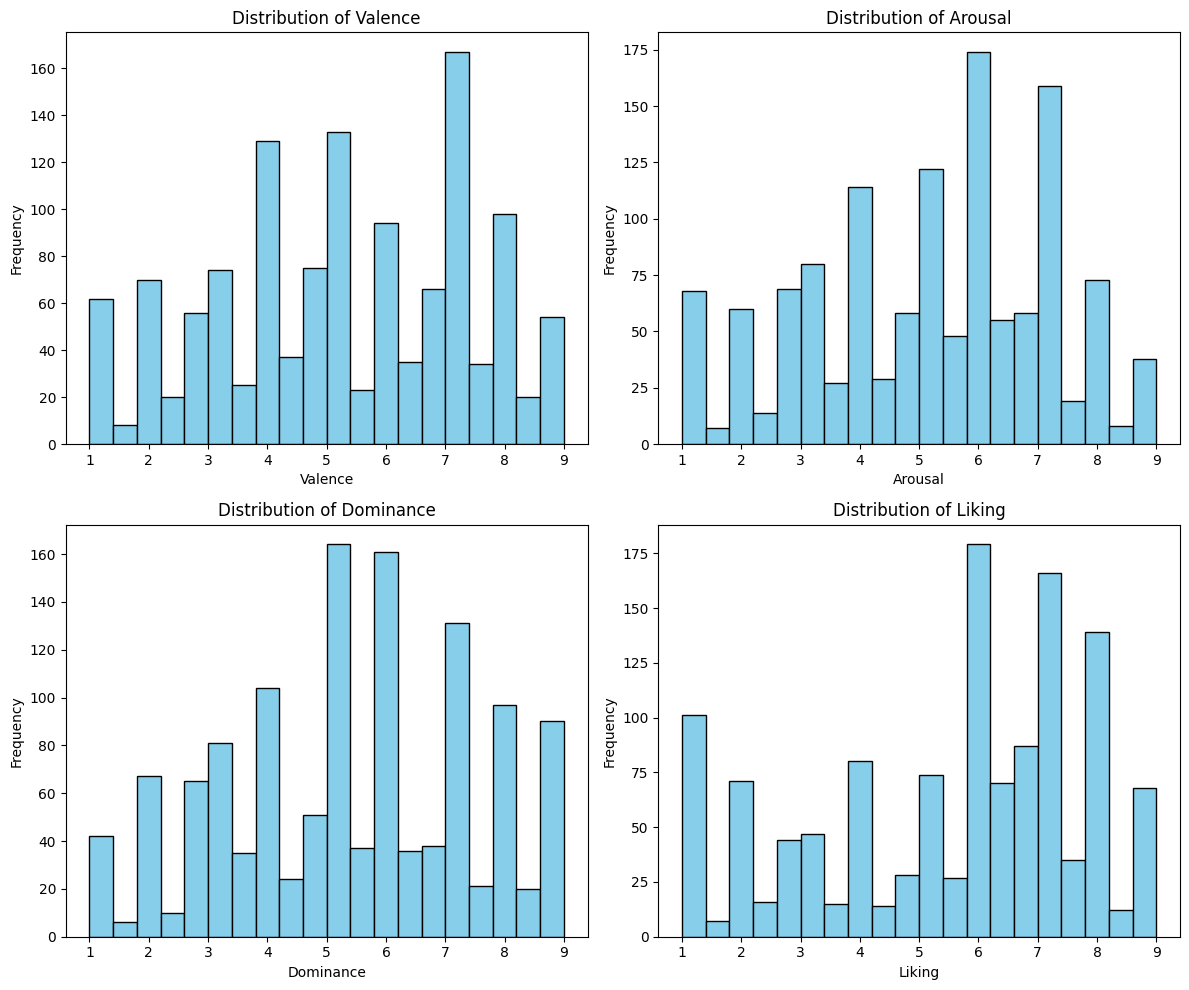

In [26]:
import matplotlib.pyplot as plt

# Function to plot label distributions
def plot_label_distributions(labels):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    label_names = ['Valence', 'Arousal', 'Dominance', 'Liking']

    for i in range(4):
        ax = axes[i // 2, i % 2]
        ax.hist(labels[:, i], bins=20, color='skyblue', edgecolor='black')
        ax.set_title(f'Distribution of {label_names[i]}')
        ax.set_xlabel(label_names[i])
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Plot distributions of labels
plot_label_distributions(all_labels)


# Print label ratings for all trials of all participants

In [27]:
# Function to print label ratings for all trials of all participants
def print_label_ratings(labels):
    num_participants = labels.shape[0] // 40  # Assuming each participant has 40 trials
    for participant in range(num_participants):
        print(f"Participant {participant + 1}:")
        for trial in range(40):
            trial_index = participant * 40 + trial
            valence = labels[trial_index, 0]
            arousal = labels[trial_index, 1]
            dominance = labels[trial_index, 2]
            liking = labels[trial_index, 3]
            print(f"  Trial {trial + 1}: Valence={valence}, Arousal={arousal}, Dominance={dominance}, Liking={liking}")

# Print label ratings
print_label_ratings(all_labels)


Participant 1:
  Trial 1: Valence=7.71, Arousal=7.6, Dominance=6.9, Liking=7.83
  Trial 2: Valence=8.1, Arousal=7.31, Dominance=7.28, Liking=8.47
  Trial 3: Valence=8.58, Arousal=7.54, Dominance=9.0, Liking=7.08
  Trial 4: Valence=4.94, Arousal=6.01, Dominance=6.12, Liking=8.06
  Trial 5: Valence=6.96, Arousal=3.92, Dominance=7.19, Liking=6.05
  Trial 6: Valence=8.27, Arousal=3.92, Dominance=7.0, Liking=8.03
  Trial 7: Valence=7.44, Arousal=3.73, Dominance=7.08, Liking=7.04
  Trial 8: Valence=7.32, Arousal=2.55, Dominance=6.32, Liking=5.87
  Trial 9: Valence=4.04, Arousal=3.29, Dominance=3.62, Liking=5.99
  Trial 10: Valence=1.99, Arousal=4.86, Dominance=2.04, Liking=7.09
  Trial 11: Valence=2.99, Arousal=2.36, Dominance=3.63, Liking=6.24
  Trial 12: Valence=2.71, Arousal=2.77, Dominance=3.4, Liking=7.35
  Trial 13: Valence=1.95, Arousal=3.12, Dominance=2.87, Liking=6.18
  Trial 14: Valence=4.18, Arousal=2.24, Dominance=3.04, Liking=5.04
  Trial 15: Valence=3.17, Arousal=8.08, Dominanc

# Scatter plot for valence and arousal

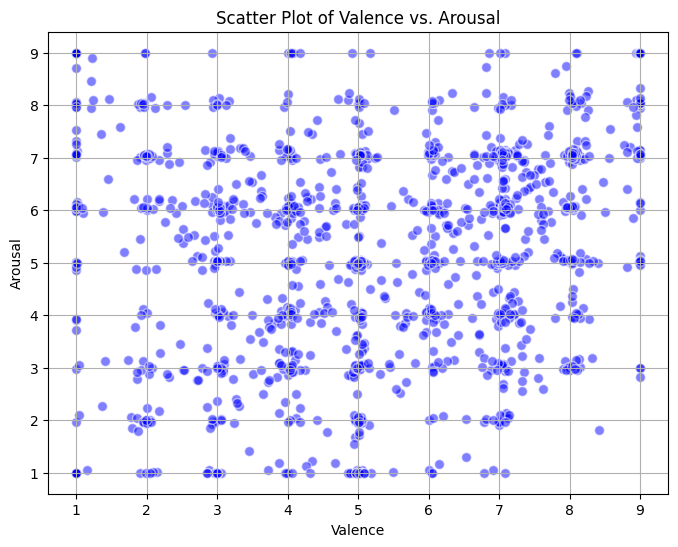

In [28]:
# Scatter plot of Valence vs. Arousal
def plot_valence_arousal_scatter(labels):
    plt.figure(figsize=(8, 6))
    plt.scatter(labels[:, 0], labels[:, 1], alpha=0.5, c='blue', edgecolors='w', s=50)
    plt.xlabel('Valence')
    plt.ylabel('Arousal')
    plt.title('Scatter Plot of Valence vs. Arousal')
    plt.grid(True)
    plt.show()

# Plot Valence vs. Arousal
plot_valence_arousal_scatter(all_labels)


# Heatmap for correlations between labels

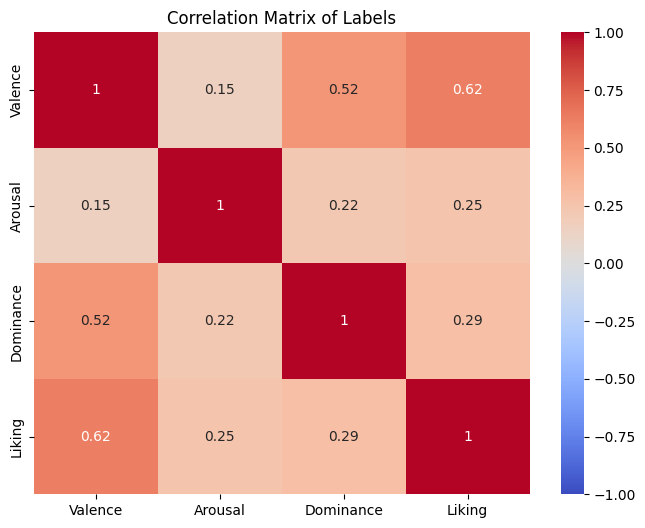

In [29]:
import seaborn as sns

# Plot heatmap of label correlations
def plot_label_correlations(labels):
    label_names = ['Valence', 'Arousal', 'Dominance', 'Liking']
    correlation_matrix = np.corrcoef(labels.T)

    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, xticklabels=label_names, yticklabels=label_names, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix of Labels')
    plt.show()

# Plot label correlations
plot_label_correlations(all_labels)


# Converting valence and arousal into discrete classes

# 1. Define thresholds

In [30]:
# Calculate median values for valence and arousal
valence_threshold = np.median(all_labels[:, 0])
arousal_threshold = np.median(all_labels[:, 1])

print(f"Valence Threshold: {valence_threshold}")
print(f"Arousal Threshold: {arousal_threshold}")


Valence Threshold: 5.04
Arousal Threshold: 5.23


# 2. Define Classses
0 - High valence, high arousal
1 - High valence, low arousal
2 - Low valence, low arousal
3 - low valence, high arousal

In [31]:
def assign_class(valence, arousal, valence_threshold, arousal_threshold):
    if valence >= valence_threshold and arousal >= arousal_threshold:
        return 0  # High Valence, High Arousal
    elif valence >= valence_threshold and arousal < arousal_threshold:
        return 1  # High Valence, Low Arousal
    elif valence < valence_threshold and arousal < arousal_threshold:
        return 2  # Low Valence, Low Arousal
    elif valence < valence_threshold and arousal >= arousal_threshold:
        return 3  # Low Valence, High Arousal


# 3. Convert labels to classes

In [32]:
# Create an array to store the classes
class_labels = np.zeros(all_labels.shape[0])

# Assign classes based on valence and arousal thresholds
for i in range(all_labels.shape[0]):
    valence = all_labels[i, 0]
    arousal = all_labels[i, 1]
    class_labels[i] = assign_class(valence, arousal, valence_threshold, arousal_threshold)

# Convert class labels to integers
class_labels = class_labels.astype(int)

# Print the first few class labels to verify
print("Class_label shape:", class_labels.shape)
print(class_labels[:10])


Class_label shape: (1280,)
[0 0 0 3 1 1 1 1 2 2]


# 4. Verify class distribution

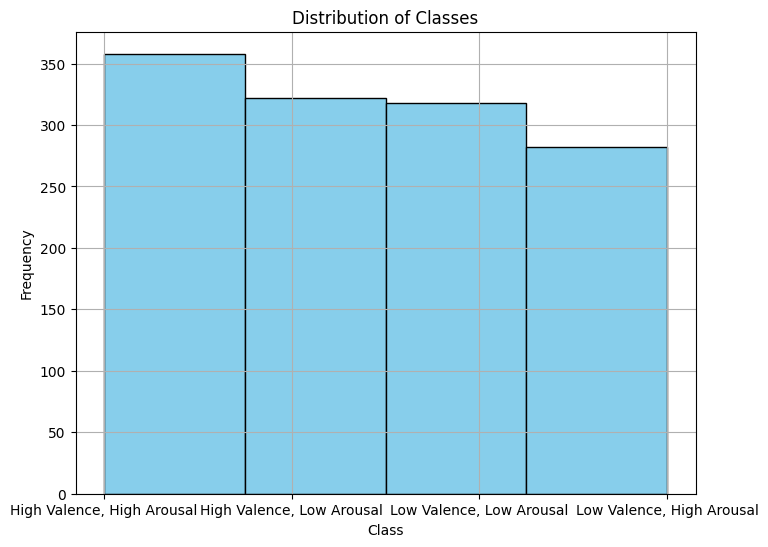

In [33]:
import matplotlib.pyplot as plt

# Plot the distribution of the classes
plt.figure(figsize=(8, 6))
plt.hist(class_labels, bins=4, edgecolor='black', color='skyblue')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Distribution of Classes')
plt.xticks([0, 1, 2, 3], ['High Valence, High Arousal', 'High Valence, Low Arousal', 'Low Valence, Low Arousal', 'Low Valence, High Arousal'])
plt.grid(True)
plt.show()


In [34]:
from collections import Counter

# Count the number of trials for each class label
trial_counts = Counter(class_labels)

# Print the number of trials for each class label
for label, count in trial_counts.items():
    print(f"Class {label}: {count} trials")


Class 0: 358 trials
Class 3: 282 trials
Class 1: 322 trials
Class 2: 318 trials


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
